In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir("./drive/MyDrive/git_project/Segmentation/src")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install -r ../docker_files/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 827.8/827.8 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 24.1 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of segmentation-models-pytorch to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 35.1 MB/s eta 0:00:00
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60943 sha256=7e42

# 準備事項
1. データを用意する
        ../data/{project_name}/images  

2. アノテーション
VIA（VGG Image Annotator）を基に作成(https://gitlab.com/vgg/via/)  
{domain}:8021に接続し、Segmentationを行なう  
結果物hoge.jsonをダウンロード  

3. データを入れる  
**file 構造**  
        ../data/{project_name}/annotations  
        ../data/{project_name}/images  
        ../data/{project_name}/hoge.json（[2. アノテーション]結果物）  


*annotationファイルと .jsonファイルどっちかあればOK

# GPU確認
以下のCommandが上手く起動しない場合はdockerの再起動を行なってください。  
- docker-compose down  
- docker-compose up  

In [3]:
!nvidia-smi

Mon Oct  2 02:55:49 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Impost modules

In [4]:
import os
os.chdir("../src")
import torch
import warnings

from glob import glob

from configs import Configs
from data.utils import reform_mvtec_dir_tree_for_segmentation
from trainers import Trainer
from testers import Tester
from utils import show_result, get_best_scheme, save_result_images, show_result_images, show_predict_mask


# Configs edit

In [5]:
configs = Configs()

configs.PROJECT_NAME = "bottle"
# seed value
configs.SEED = 91
configs.DATA_ROOT = "../data/bottle"
configs.RESULT_ROOT = "../results"
configs.MODEL_ROOT = "../models"
# train batch size
configs.BATCH_SIZE = 2
# processing image size
configs.IMAGE_SIZE = 256
# training weight -> object
configs.POS_WEIGHT = 10
# annotations file path(json)
configs.ANNOTATION_FILE_PATH = None

configs.ENABLE_PROGRESS_BAR = False
# architectures
configs.ARCHITECHURES = [
    "unet",
    "unetplusplus",
    "manet",
    "linknet",
    # "fpn",
    # "pspnet",
    # "deeplabv3",
    # "deeplabv3plus",
    # "pan",
]
# encoders
configs.ENCODERS = [
    "resnext50_32x4d",
    # "resnext101_32x48d",
    # "efficientnet-b7",
    # "inceptionresnetv2",
    "resnet34",
    # "mobilenet_v2",
    # "se_resnext101_32x4d",
    # "timm-regnety_160",
    # "timm-skresnext50_32x4d",
]
configs.PATIENCE = 5
configs.EPOCHS = 200
configs.VISUALIZE_TH = 0.9
configs.LOSS = "diceloss"
configs.THRES_HOLD_METHOD = "no_miss"

# Save Dataset to DATA_ROOT

In [6]:
reform_mvtec_dir_tree_for_segmentation()

# Sample dataset
- mvtec_bottle

MVTEC-bottleデータセット：  
../notebook/sample_data/mvtec_bottle

TESTデータのみを学習する（Trainデータは OKのみのため）

In [7]:
trainer = Trainer(configs)
trainer.fit_all_scheme()

INFO:lightning_fabric.utilities.seed:Global seed set to 91


seed91, applied
processing...unet, resnext50_32x4d


Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 247MB/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type | Params
-------------------------------
0 | model | Unet | 32.0 M
-------------------------------
32.0 M    Trainable params
0         Non-trainable params
32.0 M    Total params
127.972   Total estimated model params size (MB)
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: 

unet, resnext50_32x4d --> finished
processing...unetplusplus, resnext50_32x4d


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /content/drive/MyDrive/git_project/Segmentation/models/bottle exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type         | Params
---------------------------------------
0 | model | UnetPlusPlus | 48.5 M
---------------------------------------
48.5 M    Trainable params
0         Non-trainable params
48.5 M    Total params
193.830   Total estimated

unetplusplus, resnext50_32x4d --> finished
processing...manet, resnext50_32x4d


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type  | Params
--------------------------------
0 | model | MAnet | 146 M 
--------------------------------
146 M     Trainable params
0         Non-trainable params
146 M     Total params
587.647   Total estimated model params size (MB)


manet, resnext50_32x4d --> finished
processing...linknet, resnext50_32x4d


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type    | Params
----------------------------------
0 | model | Linknet | 30.6 M
----------------------------------
30.6 M    Trainable params
0         Non-trainable params
30.6 M    Total params
122.599   Total estimated model params size (MB)


linknet, resnext50_32x4d --> finished
processing...unet, resnet34


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 284MB/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type | Params
-------------------------------
0 | model | Unet | 24.4 M
-------------------------------
24.4 M    Trainable params
0         Non-trainable params
24.4 M    Total params
97.745    Total estimated model params size (MB)


unet, resnet34 --> finished
processing...unetplusplus, resnet34


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type         | Params
---------------------------------------
0 | model | UnetPlusPlus | 26.1 M
---------------------------------------
26.1 M    Trainable params
0         Non-trainable params
26.1 M    Total params
104.314   Total estimated model params size (MB)


unetplusplus, resnet34 --> finished
processing...manet, resnet34


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type  | Params
--------------------------------
0 | model | MAnet | 31.8 M
--------------------------------
31.8 M    Trainable params
0         Non-trainable params
31.8 M    Total params
127.135   Total estimated model params size (MB)


manet, resnet34 --> finished
processing...linknet, resnet34


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type    | Params
----------------------------------
0 | model | Linknet | 21.8 M
----------------------------------
21.8 M    Trainable params
0         Non-trainable params
21.8 M    Total params
87.088    Total estimated model params size (MB)


linknet, resnet34 --> finished


# Inference

In [8]:
tester = Tester(configs)
tester.run(os.path.join(configs.DATA_ROOT, "valid"))

INFO:lightning_fabric.utilities.seed:Global seed set to 91


seed91, applied
processing...unet, resnext50_32x4d
inferencing....weight path:../models/bottle/unet_resnext50_32x4d.ckpt.....

100%|██████████| 4/4 [00:01<00:00,  3.40it/s]


end
unet, resnext50_32x4d --> finished
processing...unetplusplus, resnext50_32x4d
inferencing....weight path:../models/bottle/unetplusplus_resnext50_32x4d.ckpt.....

100%|██████████| 4/4 [00:04<00:00,  1.05s/it]


end
unetplusplus, resnext50_32x4d --> finished
processing...manet, resnext50_32x4d
inferencing....weight path:../models/bottle/manet_resnext50_32x4d.ckpt.....

100%|██████████| 4/4 [00:01<00:00,  2.05it/s]


end
manet, resnext50_32x4d --> finished
processing...linknet, resnext50_32x4d
inferencing....weight path:../models/bottle/linknet_resnext50_32x4d.ckpt.....

100%|██████████| 4/4 [00:01<00:00,  3.95it/s]


end
linknet, resnext50_32x4d --> finished
processing...unet, resnet34
inferencing....weight path:../models/bottle/unet_resnet34.ckpt.....

100%|██████████| 4/4 [00:01<00:00,  3.73it/s]


end
unet, resnet34 --> finished
processing...unetplusplus, resnet34
inferencing....weight path:../models/bottle/unetplusplus_resnet34.ckpt.....

100%|██████████| 4/4 [00:01<00:00,  3.01it/s]


end
unetplusplus, resnet34 --> finished
processing...manet, resnet34
inferencing....weight path:../models/bottle/manet_resnet34.ckpt.....

100%|██████████| 4/4 [00:00<00:00,  4.58it/s]


end
manet, resnet34 --> finished
processing...linknet, resnet34
inferencing....weight path:../models/bottle/linknet_resnet34.ckpt.....

100%|██████████| 4/4 [00:00<00:00,  5.38it/s]


end
linknet, resnet34 --> finished


# Show result
../src/utils  show_result  
target(accuracy, losses)を基に結果を出す

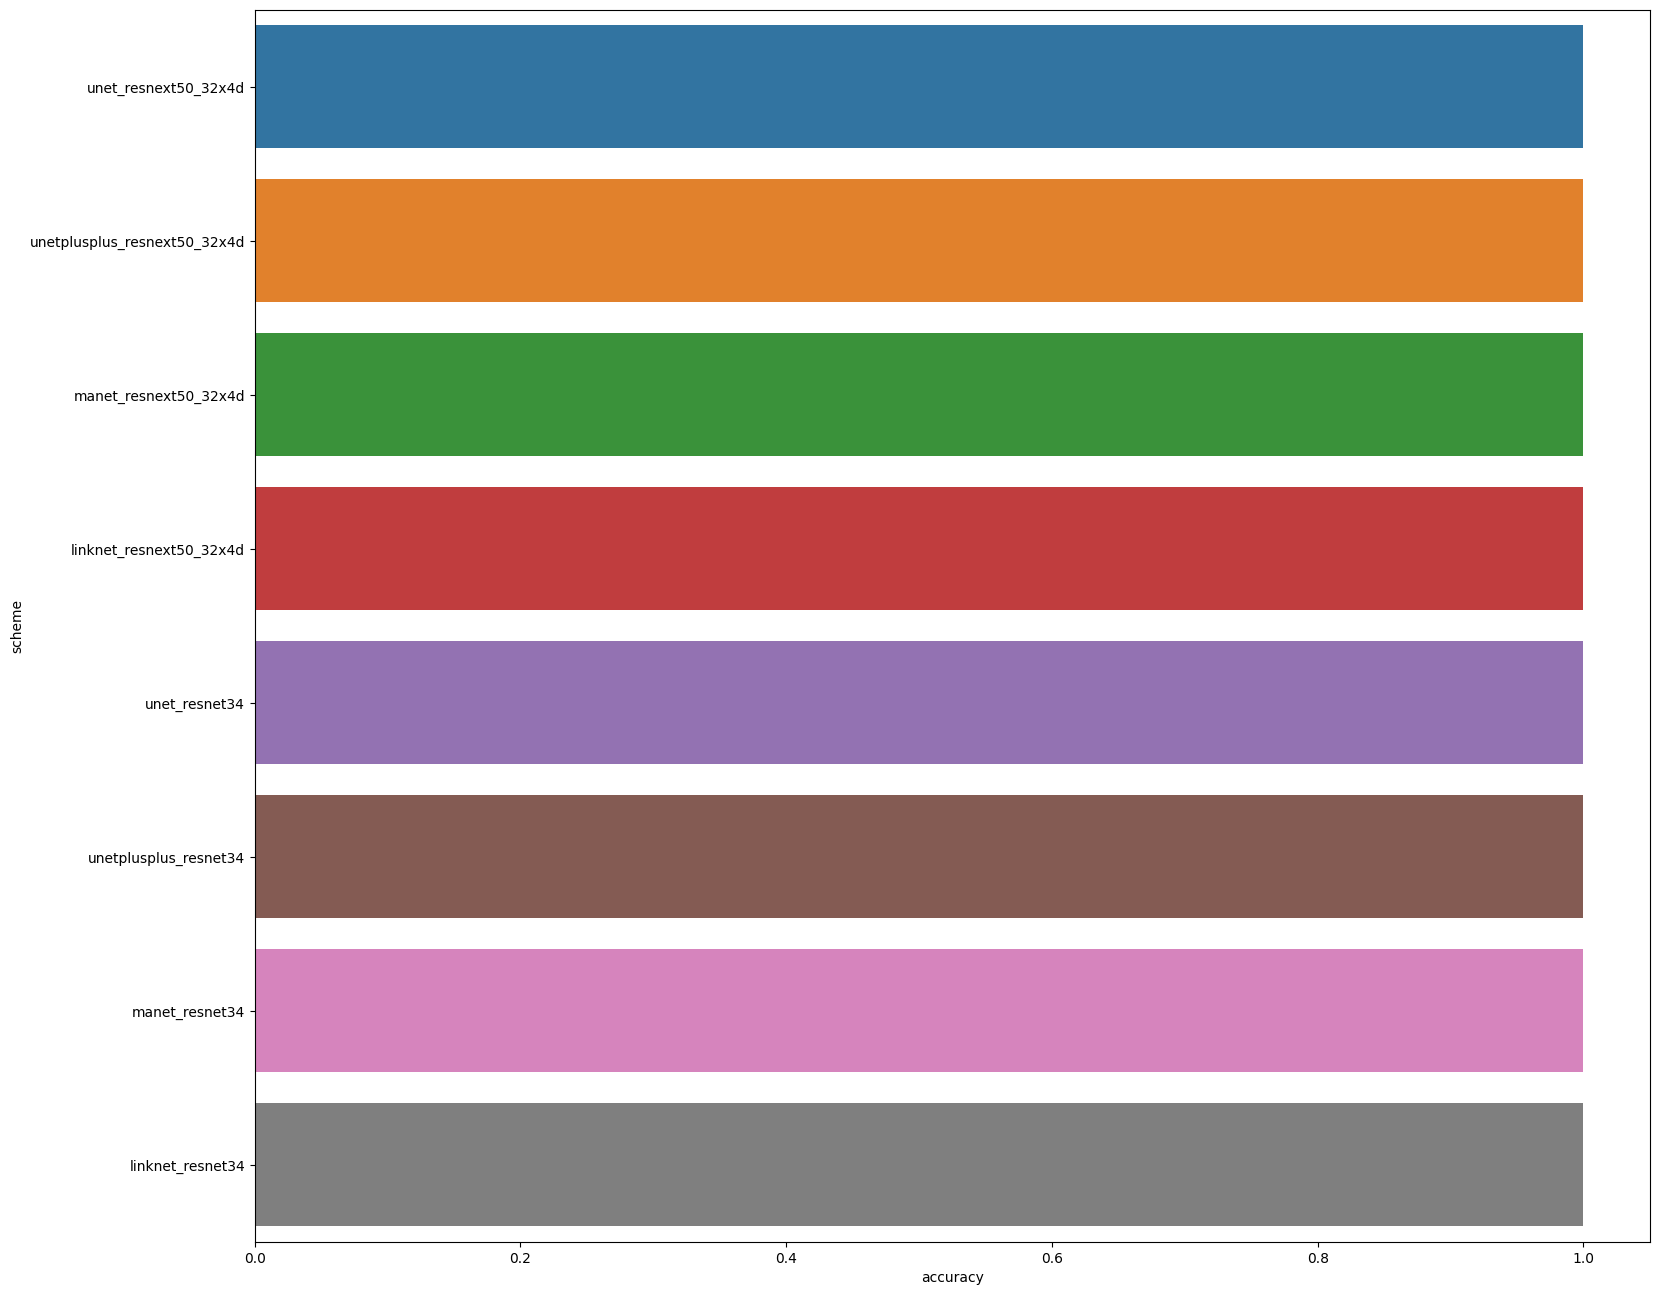

In [9]:
# show accuracies
show_result(configs=configs, target="accuracy")

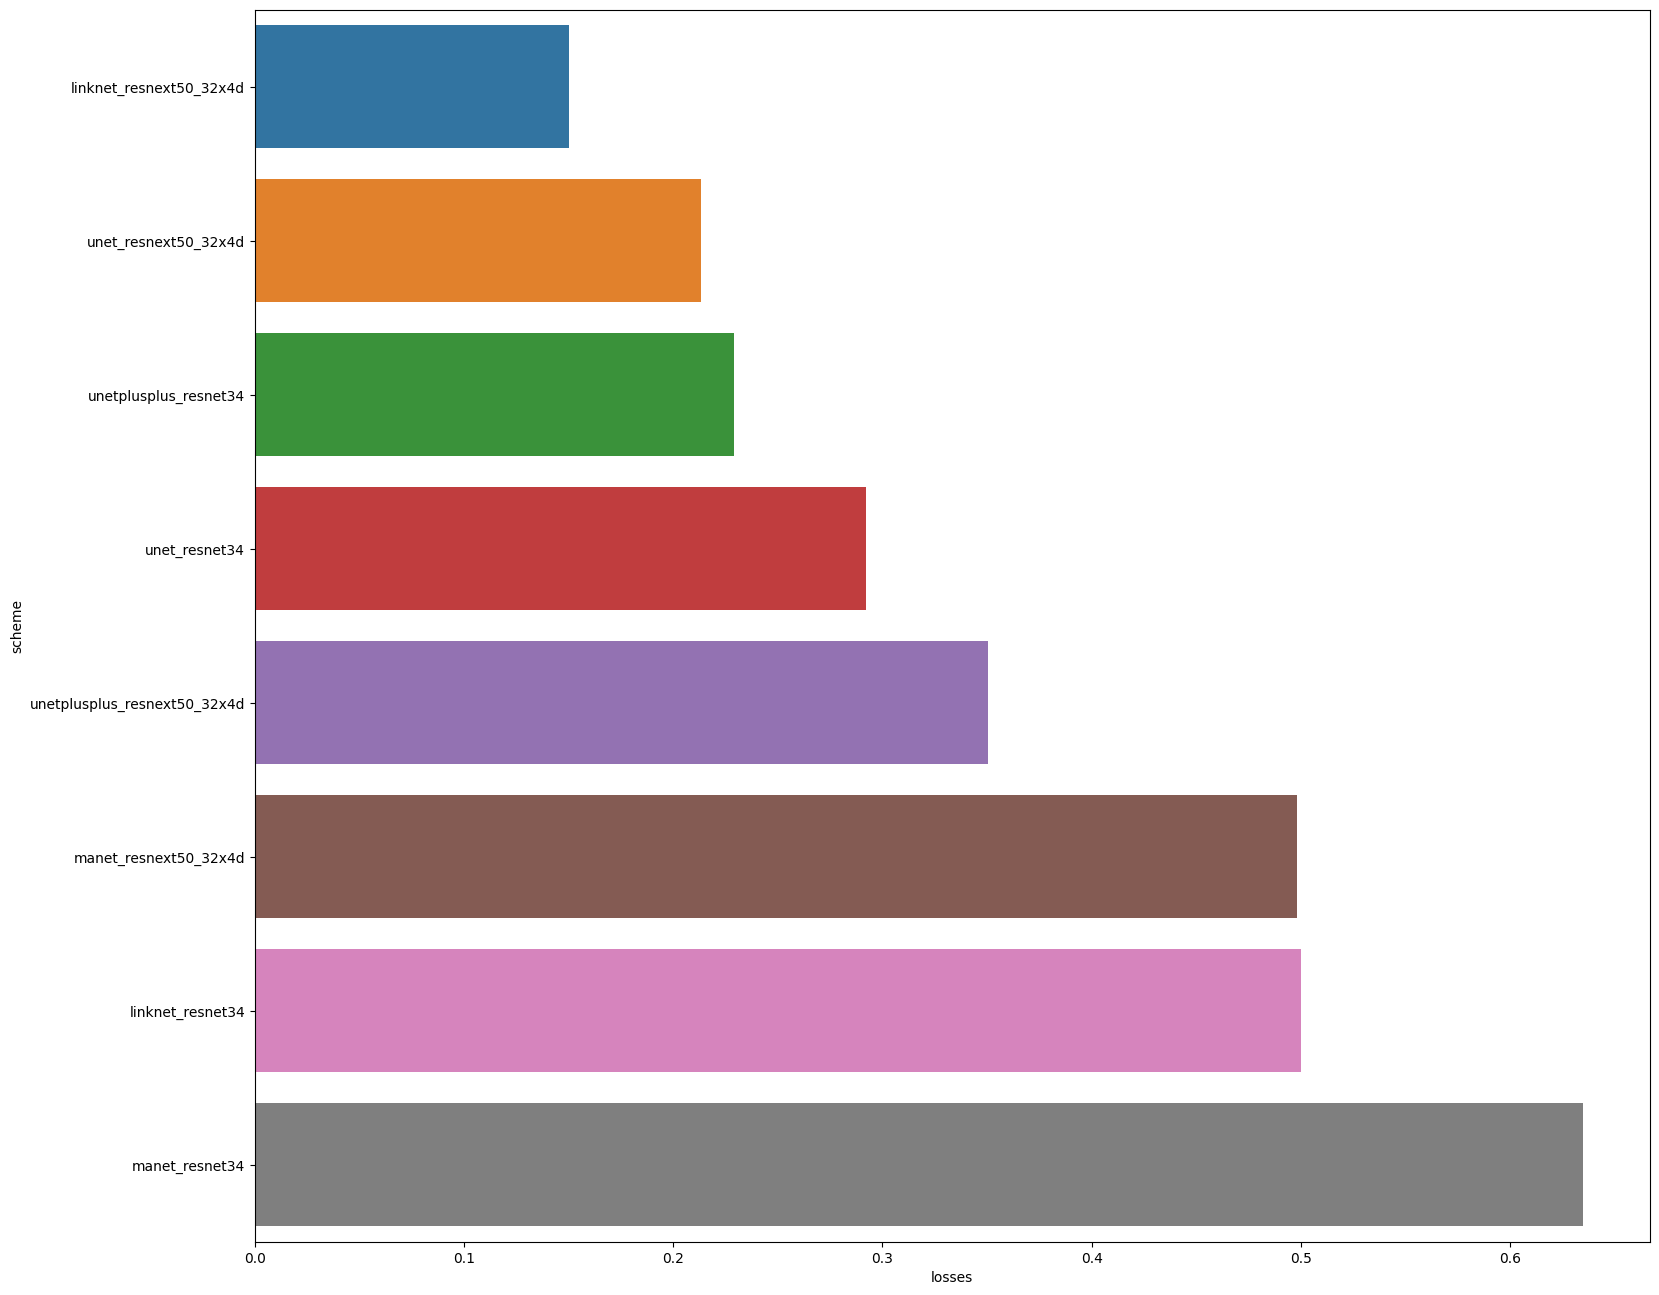

In [10]:
show_result(configs=configs, target="losses")

# Show result images
../src/utils save_result_images  
TEST結果を基に画像を作成、保存する  

../src/utils show_result_images  
保存した画像を表示する  

色の表現の解説は以下の通り  
- RED: 予測した部分  
- GREEN：正解エリア  
- YELLOW：当てたエリア  

In [11]:
best_scheme_name = get_best_scheme(configs, target="losses")
best_scheme_name

'linknet_resnext50_32x4d'

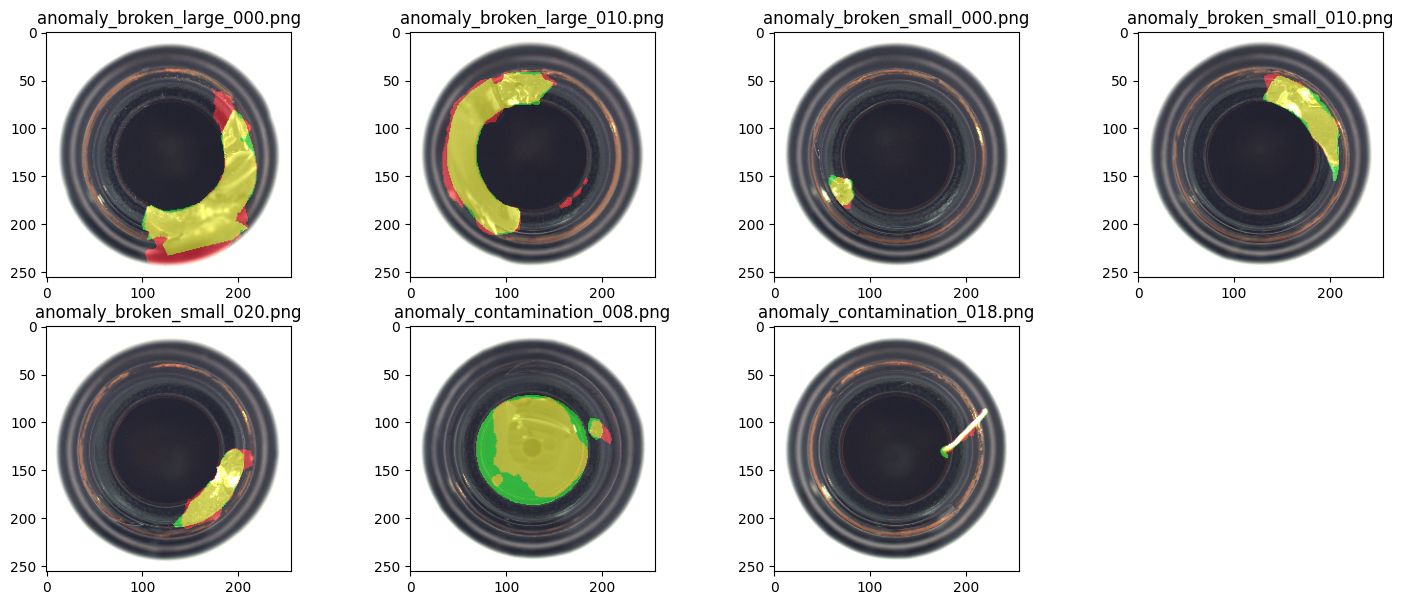

In [12]:
# save resultl images
save_result_images(configs=configs)
show_result_images(configs=configs, scheme=best_scheme_name, show_image_num=30)

# Show predict images
../src/utils show_predict_mask
判断したMASKを表示する  
- 1列：オリジナルイメージ  
- 2列：Sigmoid関数を通過した値の0.5 Threshold　かけたMASK  
- 3列：Sigmoid関数を通過した値の0.9 Threshold　かけたMASK  
- 4列：正解MASK

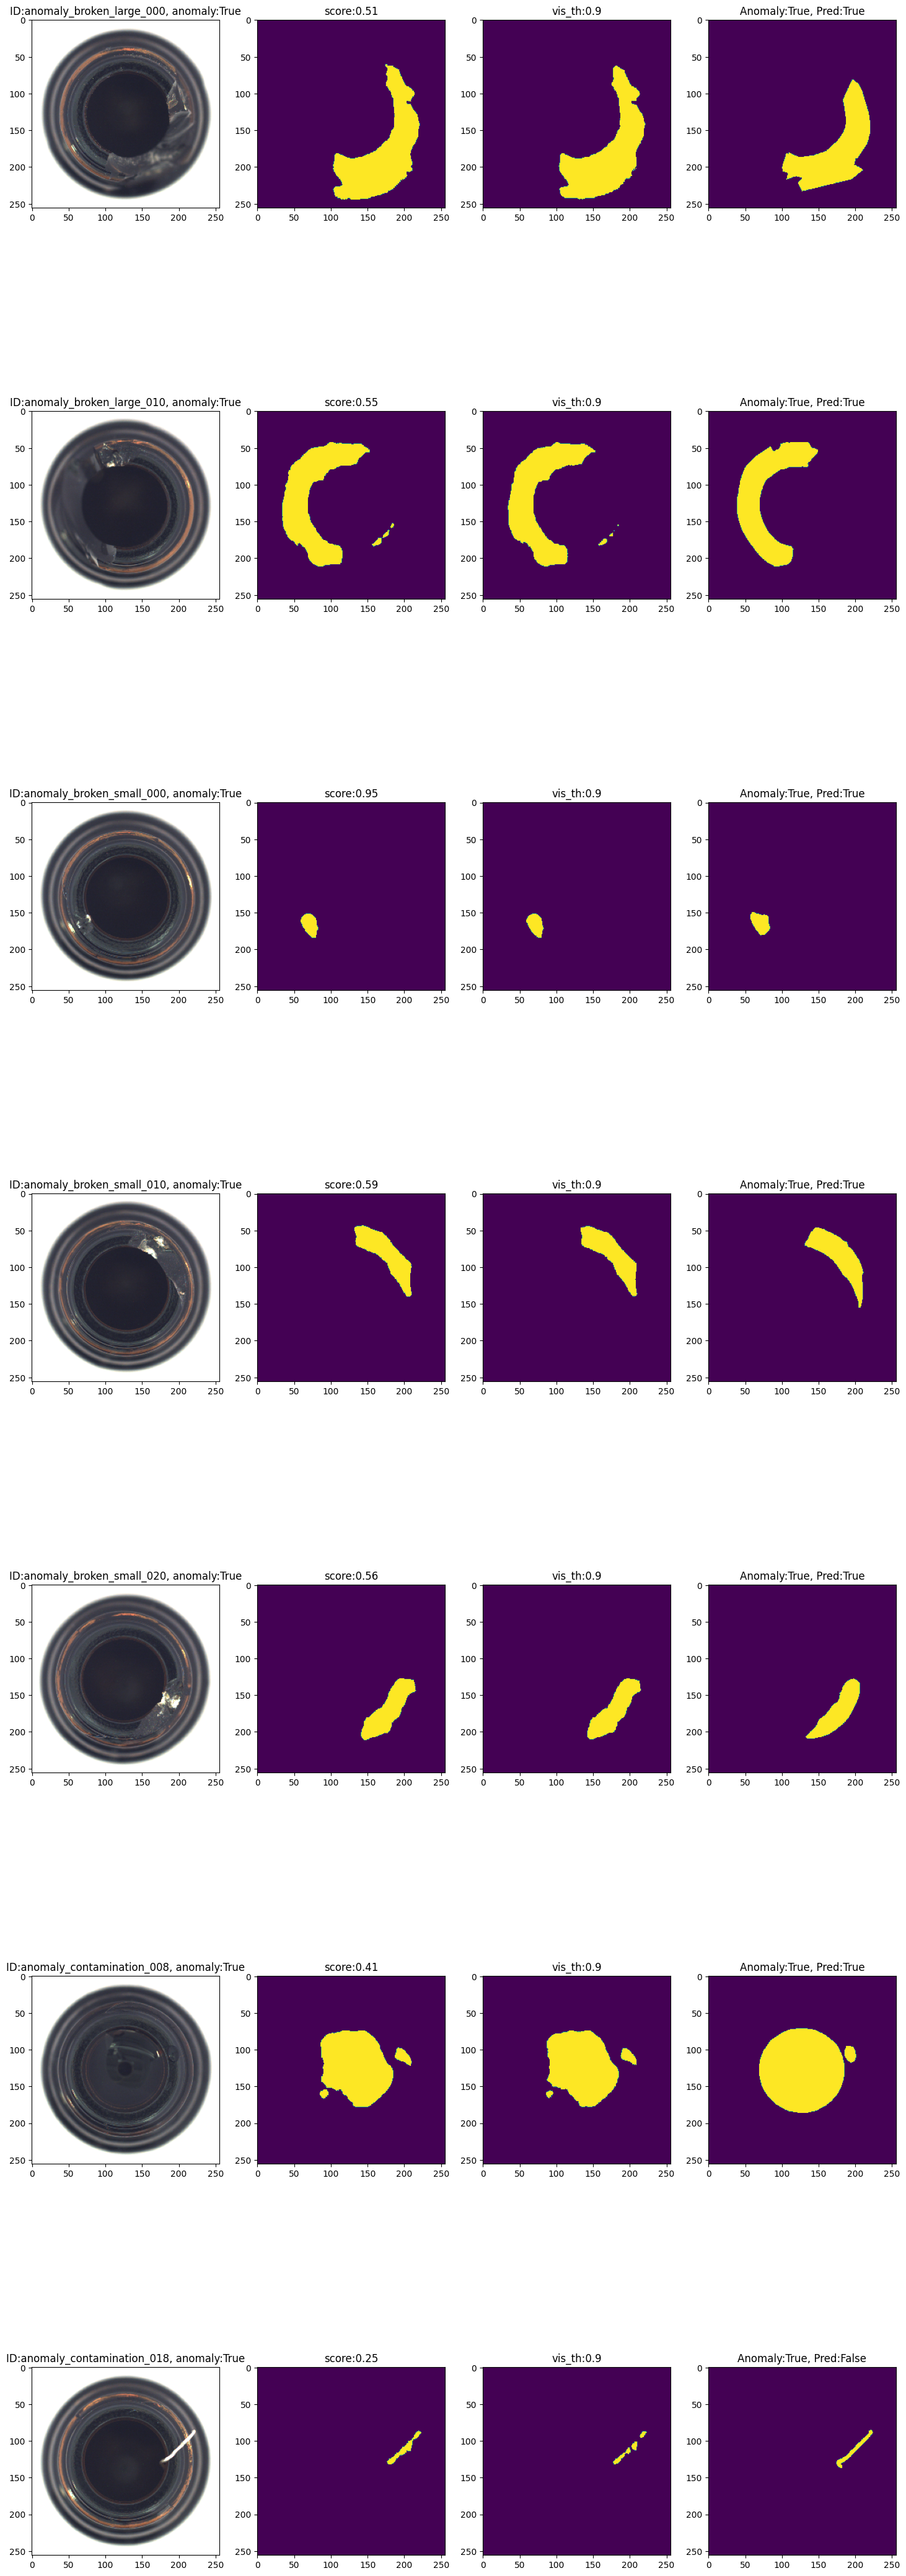

In [13]:
show_predict_mask(configs=configs, scheme=best_scheme_name)